<h1>DUNEX Data Exploration Notebook </h1>
Written By: EJ Rainville, Fall 2021

In [2]:
# Import Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import netCDF4 as nc
from scipy import signal
from scipy import fft
from scipy import interpolate
import cftime
import sys
import datetime

# Import DUNEX Tools
sys.path.append('..')
from tools import microSWIFTTools
%matplotlib widget

<h2> Plotting Accelerations from Mission 1 and building the Mission Accels Function</h2>

['microSWIFT_3', 'microSWIFT_4', 'microSWIFT_5', 'microSWIFT_40', 'microSWIFT_41', 'microSWIFT_42', 'microSWIFT_39', 'microSWIFT_38', 'microSWIFT_57']


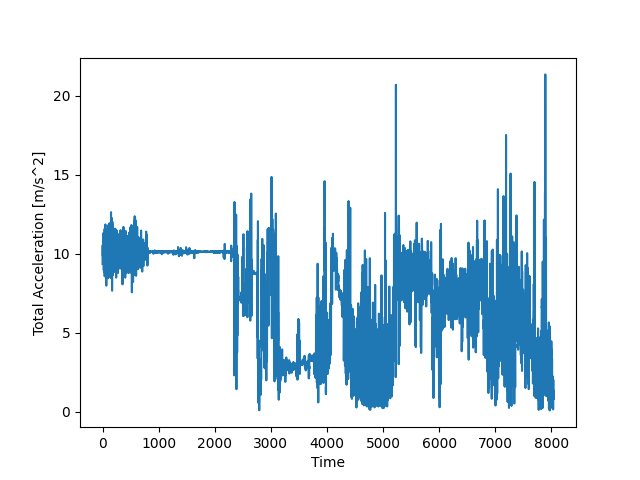

In [19]:
# Mission 1 netCDF path
mission_nc_path = '../microSWIFT_data/mission_5/mission_5.nc'

# Load in netCDF file as a dataset
mission_dataset = nc.Dataset(mission_nc_path, mode='r')

# Get list of all microSWIFTs on the mission
microSWIFTs_on_mission = list(mission_dataset.groups.keys())
print(microSWIFTs_on_mission)

# Get Datetime values 
imu_time_3 = cftime.num2pydate(mission_dataset['microSWIFT_3']['IMU']['time'],units=mission_dataset['microSWIFT_3']['IMU']['time'].units, calendar=mission_dataset['microSWIFT_3']['IMU']['time'].calendar)
imu_time_5 = cftime.num2pydate(mission_dataset['microSWIFT_5']['IMU']['time'],units=mission_dataset['microSWIFT_5']['IMU']['time'].units, calendar=mission_dataset['microSWIFT_5']['IMU']['time'].calendar)
gps_time_3 = cftime.num2pydate(mission_dataset['microSWIFT_3']['GPS']['time'],units=mission_dataset['microSWIFT_3']['GPS']['time'].units, calendar=mission_dataset['microSWIFT_3']['GPS']['time'].calendar)
gps_time_5 = cftime.num2pydate(mission_dataset['microSWIFT_5']['GPS']['time'],units=mission_dataset['microSWIFT_5']['GPS']['time'].units, calendar=mission_dataset['microSWIFT_5']['GPS']['time'].calendar)

# Compute Total Acceleration 
accel_x = np.array(mission_dataset['microSWIFT_3']['IMU']['accel_x'][:])
accel_y = np.array(mission_dataset['microSWIFT_3']['IMU']['accel_y'][:])
accel_z = np.array(mission_dataset['microSWIFT_3']['IMU']['accel_z'][:])
tot_accel = np.sqrt(np.square(accel_x) + np.square(accel_y), np.square(accel_z))

# Plot the Vertical Accelerations from the mission for one microSWIFT
fig, ax = plt.subplots()
ax.plot(tot_accel)
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.set_ylabel('Total Acceleration [m/s^2]')
ax.set_xlabel('Time')

# Compute Gabor transform of the total acceleration signal
f, t, Sxx = signal.spectrogram(tot_accel, fs=12)
high_freq_inds = np.argwhere(f > 2)
Sxx_high_freq = Sxx[high_freq_inds]

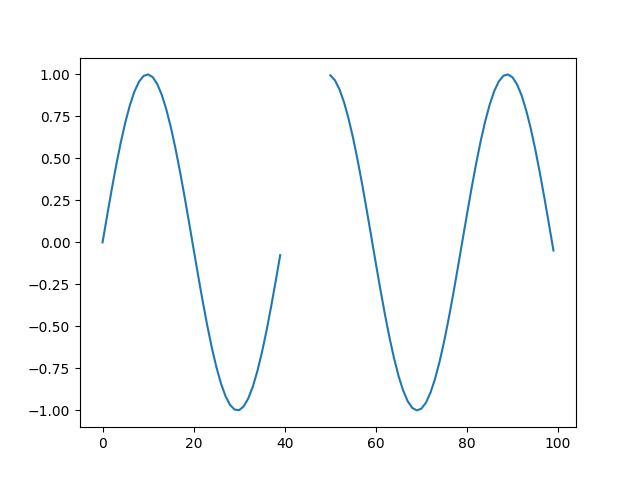

In [5]:
# Testing missing data points in time series
x = np.arange(100)
y = np.sin(x/(2*np.pi))

# Add a few NaN values to test
y[40:50] = np.NaN

# Plot data
fig, ax = plt.subplots()
ax.plot(x,y)

In [20]:
fig, ax = plt.subplots()
ax.plot(np.array(mission_dataset['microSWIFT_3']['IMU']['accel_x'][:]), color='k')
ax.plot(np.array(mission_dataset['microSWIFT_5']['IMU']['accel_x'][:]), color='r')

8038
9293


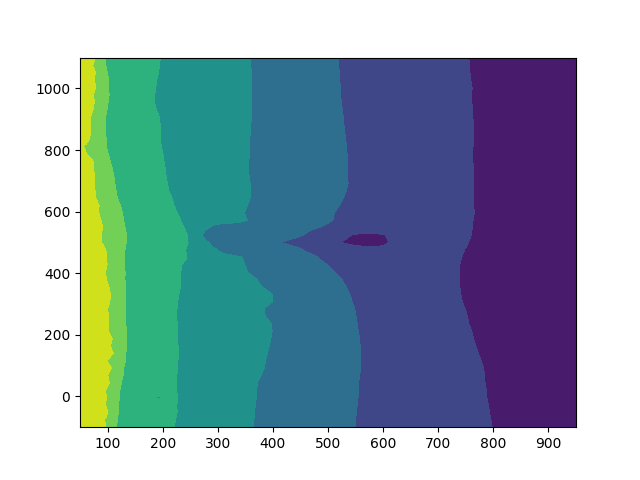

In [3]:
# Getting Bathymetry data from FRF data portal
# Data from September 28th, 2021
bathy_url = 'https://chlthredds.erdc.dren.mil/thredds/dodsC/frf/geomorphology/DEMs/surveyDEM/data/FRF_geomorphology_DEMs_surveyDEM_20210928.nc'
bathy_dataset = nc.Dataset(bathy_url)

# Create grid from coordinates
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],bathy_dataset['yFRF'][:])
bathy = bathy_dataset['elevation'][0,:,:]

# Plot the bathymetry
fig, ax = plt.subplots()
ax.contourf(xFRF_grid, yFRF_grid, bathy)


NameError: name 'transform2FRF' is not defined

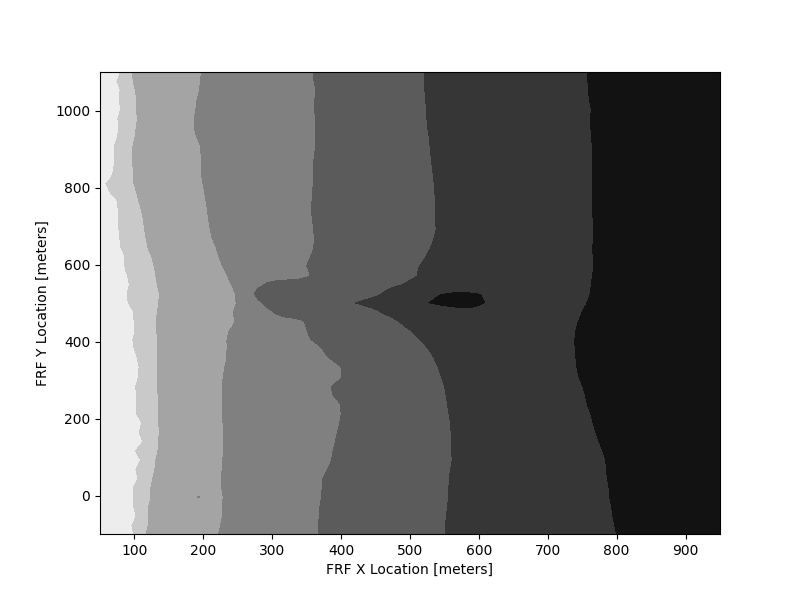

In [6]:
# Mission 7 netCDF path
mission_dir_path = '../microSWIFT_data/mission_7'
mission_nc_path = '../microSWIFT_data/mission_7/mission_7.nc'

# Load in netCDF file as a dataset
mission_dataset = nc.Dataset(mission_nc_path, mode='r')

# Get list of all microSWIFTs on the mission
microSWIFTs_on_mission = list(mission_dataset.groups.keys())

# Create map of all drift tracks during mission
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('FRF X Location [meters]')  
ax.set_ylabel('FRF Y Location [meters]')

# Add the FRF Bathymetry to the map 
# Data from September 28th, 2021
bathy_url = 'https://chlthredds.erdc.dren.mil/thredds/dodsC/frf/geomorphology/DEMs/surveyDEM/data/FRF_geomorphology_DEMs_surveyDEM_20210928.nc'
bathy_dataset = nc.Dataset(bathy_url)
# Create grid from coordinates
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],bathy_dataset['yFRF'][:])
bathy = bathy_dataset['elevation'][0,:,:]
ax.contourf(xFRF_grid, yFRF_grid, bathy, cmap='gray')

# Sort time labels 
min_time_label = mission_dataset[microSWIFTs_on_mission[0]]['GPS']['time'][0]
max_time_label = mission_dataset[microSWIFTs_on_mission[0]]['GPS']['time'][-1]

# Sort x and y locations for map  
x, y = microSWIFTTools.transform2FRF(mission_dataset[microSWIFTs_on_mission[0]]['GPS']['lat'], mission_dataset[microSWIFTs_on_mission[0]]['GPS']['lon']) 
min_x = np.min(x)
max_x = np.max(x)
min_y = np.min(y)
max_y = np.max(y)

for microSWIFT in microSWIFTs_on_mission:
    # Compute local coordinates from each lat-lon series
    x, y = microSWIFTTools.transform2FRF(lat=mission_dataset[microSWIFT]['GPS']['lat'][:], lon=mission_dataset[microSWIFT]['GPS']['lon'][:])

    # Plot the lat-lon map with color coded points in time
    map = ax.scatter(x, y, c=mission_dataset[microSWIFT]['GPS']['time'][:], cmap='plasma')
    # reset time labels for colormap 
    if mission_dataset[microSWIFT]['GPS']['time'][0] < min_time_label:
        min_time_label = mission_dataset[microSWIFT]['GPS']['time'][0]
    if mission_dataset[microSWIFT]['GPS']['time'][-1] > max_time_label:
        max_time_label = mission_dataset[microSWIFT]['GPS']['time'][-1]
    # Set max and min position
    if np.min(x) < min_x:
        min_x = np.min(x)
    if np.max(x) > max_x:
        max_x = np.max(x)
    if np.min(y) < min_y:
        min_y = np.min(y)
    if np.max(y) > max_y:
        max_y = np.max(y)
    
# Set colorbar and figure properties
cbar = fig.colorbar(map, ax=ax, ticks=[min_time_label, max_time_label])
map.set_clim([min_time_label, max_time_label])
ax.set_xlim([min_x, max_x])
ax.set_ylim([min_y, max_y])
cbar.ax.set_xlabel('Time [UTC]')
time_labels = cftime.num2pydate([min_time_label, max_time_label],units=mission_dataset[microSWIFT]['GPS']['time'].units, calendar=mission_dataset[microSWIFT]['GPS']['time'].calendar)
time_labels = [time_labels[0].strftime('%Y-%m-%d %H:%M'), time_labels[1].strftime('%Y-%m-%d %H:%M')]
cbar.ax.set_yticklabels(time_labels, rotation=0, va='center')
plt.tight_layout()
ax.set_aspect('equal')

In [19]:
# Mission 20 
# Acceleration histograms for minute averages with averaged location 
# This will hopefully become a function in microSWIFT tools

mission_nc_path = '../microSWIFT_data/mission_20/mission_20.nc'

# Load in netCDF file as a dataset
mission_dataset = nc.Dataset(mission_nc_path, mode='r')

# Get list of all microSWIFTs on the mission
microSWIFTs_on_mission = list(mission_dataset.groups.keys())

# Get Location Information 
microSWIFT = 'microSWIFT_2'
x = mission_dataset[microSWIFT]['GPS']['x_frf']
y = mission_dataset[microSWIFT]['GPS']['y_frf']
gps_time_list = cftime.num2pydate(mission_dataset[microSWIFT]['GPS']['time'],units=mission_dataset[microSWIFT]['GPS']['time'].units, calendar=mission_dataset[microSWIFT]['GPS']['time'].calendar)

# Sort the times and associated values to within each minute window 
start_time = gps_time_list[0].replace(second=0, microsecond=0)
end_time = gps_time_list[-1].replace(second=0, microsecond=0) + datetime.timedelta(minutes=1)
print(start_time)
print(end_time)

# Loop through each time value and sort into minute lists
for time in gps_time_list:
    in_minute_x = 
    if time >= start_time and time <= end_time:








# # Create map of all drift tracks during mission
# fig, ax = plt.subplots(figsize=(8,6))
# ax.set_xlabel('FRF X Location [meters]')  
# ax.set_ylabel('FRF Y Location [meters]')

# ## Add the FRF Bathymetry to the map 
# # Data from September 28th, 2021
# bathy_url = 'https://chlthredds.erdc.dren.mil/thredds/dodsC/frf/geomorphology/DEMs/surveyDEM/data/FRF_geomorphology_DEMs_surveyDEM_20210928.nc'
# bathy_dataset = nc.Dataset(bathy_url)
# # Create grid from coordinates
# xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],bathy_dataset['yFRF'][:])
# bathy = bathy_dataset['elevation'][0,:,:]
# ax.contourf(xFRF_grid, yFRF_grid, bathy, cmap='gray')
 


2021-10-10 13:00:00
2021-10-10 13:28:00
